# Data Extraction from YouTube

In this notebook we download a monocular endoscopic surgery video.
The video source is: https://www.youtube.com/watch?v=6niL7Poc_qQ.
We separate the video into individual frames and save them to `data/surgical_video/` and create a PyTorch dataloader to load frames of the video. 

In [1]:
from pytube import YouTube
import os
import torch
import pandas as pd
from skimage import io, transform
import imageio
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [2]:
video_url = 'https://www.youtube.com/watch?v=6niL7Poc_qQ'
data_root = 'data'
video_dir = 'surgical_video_src'
output_dir = 'surgical_video_frames'

if not os.path.exists(os.path.join(data_root, video_dir)):
    os.makedirs(os.path.join(data_root, video_dir))
    
if not os.path.exists(os.path.join(data_root, output_dir)):
    os.makedirs(os.path.join(data_root, output_dir))

In [3]:
filename = YouTube(video_url).streams.first().download(os.path.join(data_root, video_dir))

In [4]:
vid = imageio.get_reader(filename,  'ffmpeg')

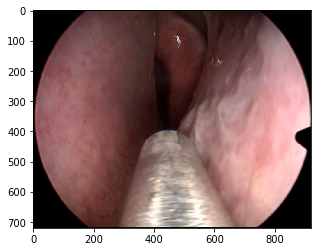

In [9]:
fig = plt.figure()
plt.imshow(vid.get_data(500)[:,190:1110])

In [10]:
def process(image):
    return image[:,190:1110]

In [19]:
for frame in range(340, 1916):
    #Manual start and end points of video
    
    image = vid.get_data(frame)
    image = process(image)
    imageio.imwrite("{0}/frame_{1:04d}.png".format(os.path.join(data_root, output_dir), int(frame)-340), image)
    

In [82]:
class SinusVideoDataset(Dataset):
    """Endoscopy Dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len([name for name in os.listdir(self.root_dir) if os.path.isfile(self.root_dir+name)])
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, "frame_{0:04d}.png".format(idx))
        image = io.imread(img_name)
        sample = {'image': image}

        if self.transform:
            sample = self.transform(sample)

        return sample